Name : Deekshitha Chowdary Kalluri

Project Name : Pathfinding Algorithm Selection for Real-World Applications: A Comparative Study

In [14]:
# 📦 Setup
!pip install networkx matplotlib --quiet

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import heapq
import random
import time
import pandas as pd
from tabulate import tabulate
from scipy.stats import ttest_rel

In [15]:
# 📌 Maze Generator
def create_grid_graph(rows, cols, obstacle_prob=0.2):
    G = nx.grid_2d_graph(rows, cols)
    obstacles = set()
    for node in list(G.nodes):
        if node not in [(0, 0), (rows - 1, cols - 1)] and random.random() < obstacle_prob:
            obstacles.add(node)
    G.remove_nodes_from(obstacles)
    return G, obstacles

In [16]:
def manhattan_distance(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def astar_search(G, start, goal):
    open_set = []
    heapq.heappush(open_set, (manhattan_distance(start, goal), 0, start))
    came_from, g_score = {}, {start: 0}
    while open_set:
        _, cost, current = heapq.heappop(open_set)
        if current == goal:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1]
        for neighbor in G.neighbors(current):
            tentative = cost + 1
            if neighbor not in g_score or tentative < g_score[neighbor]:
                g_score[neighbor] = tentative
                heapq.heappush(open_set, (tentative + manhattan_distance(neighbor, goal), tentative, neighbor))
                came_from[neighbor] = current
    return None

def dijkstra_search(G, start, goal):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from, cost = {}, {start: 0}
    while open_set:
        curr_cost, current = heapq.heappop(open_set)
        if current == goal:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1]
        for neighbor in G.neighbors(current):
            new_cost = curr_cost + 1
            if neighbor not in cost or new_cost < cost[neighbor]:
                cost[neighbor] = new_cost
                heapq.heappush(open_set, (new_cost, neighbor))
                came_from[neighbor] = current
    return None

def dfs_limited(G, current, goal, depth, path, visited):
    if depth == 0 and current == goal:
        return path + [current]
    if depth > 0:
        visited.add(current)
        for neighbor in G.neighbors(current):
            if neighbor not in visited:
                res = dfs_limited(G, neighbor, goal, depth - 1, path + [current], visited)
                if res: return res
    return None

def iddfs_search(G, start, goal, max_depth=50):
    for depth in range(max_depth):
        visited = set()
        result = dfs_limited(G, start, goal, depth, [], visited)
        if result:
            return result
    return None

def beam_search(G, start, goal, beam_width=3):
    from queue import PriorityQueue
    queue = PriorityQueue()
    queue.put((manhattan_distance(start, goal), [start]))
    while not queue.empty():
        new_queue = PriorityQueue()
        count = 0
        while not queue.empty() and count < beam_width:
            _, path = queue.get()
            current = path[-1]
            if current == goal:
                return path
            for neighbor in G.neighbors(current):
                if neighbor not in path:
                    new_path = path + [neighbor]
                    new_queue.put((manhattan_distance(neighbor, goal), new_path))
                    count += 1
        queue = new_queue
    return None

def hill_climbing_search(G, start, goal):
    current = start
    path = [current]
    visited = {current}
    while current != goal:
        neighbors = [n for n in G.neighbors(current) if n not in visited]
        if not neighbors: return None
        next_node = min(neighbors, key=lambda n: manhattan_distance(n, goal), default=None)
        if manhattan_distance(next_node, goal) >= manhattan_distance(current, goal):
            return None
        path.append(next_node)
        visited.add(next_node)
        current = next_node
    return path

In [17]:
def draw_grid(G, obstacles, path=None, title="Maze"):
    pos = {node: (node[1], -node[0]) for node in G.nodes}
    nx.draw(G, pos, node_size=50, node_color='lightgray', with_labels=False)
    if obstacles:
        obs_pos = {node: (node[1], -node[0]) for node in obstacles}
        nx.draw_networkx_nodes(G, obs_pos, nodelist=obstacles, node_color='black', node_size=60)
    if path:
        nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='red', node_size=80)
    plt.title(title)
    plt.axis('off')

def benchmark_search(G, start, goal, fn, timeout=5):
    start_time = time.perf_counter()
    try:
        path = fn(G, start, goal)
    except Exception:
        path = None
    end_time = time.perf_counter()
    if path:
        return len(path) - 1, round(end_time - start_time, 5), True
    return None, round(end_time - start_time, 5), False


🔎 GRID SIZE: 10x10


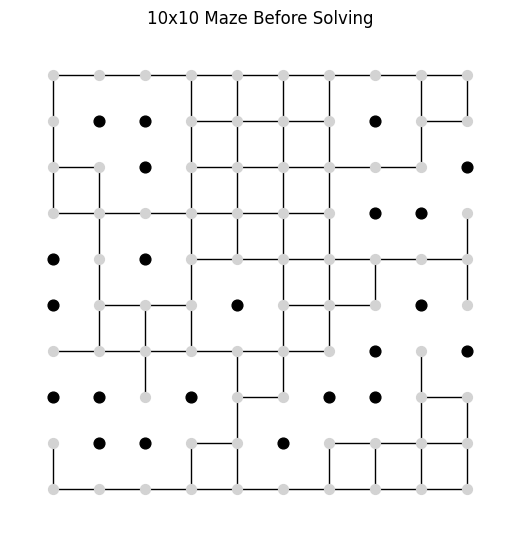

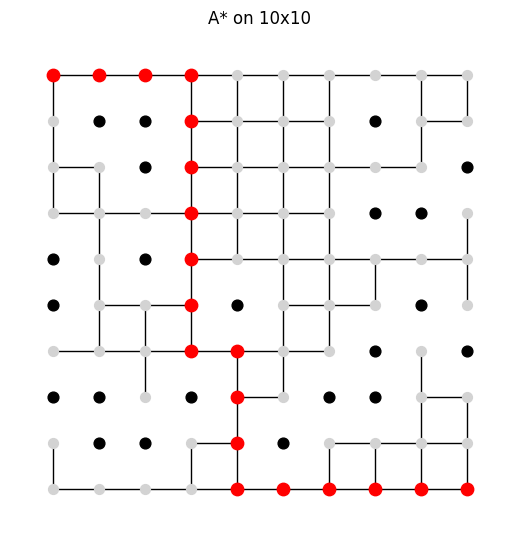

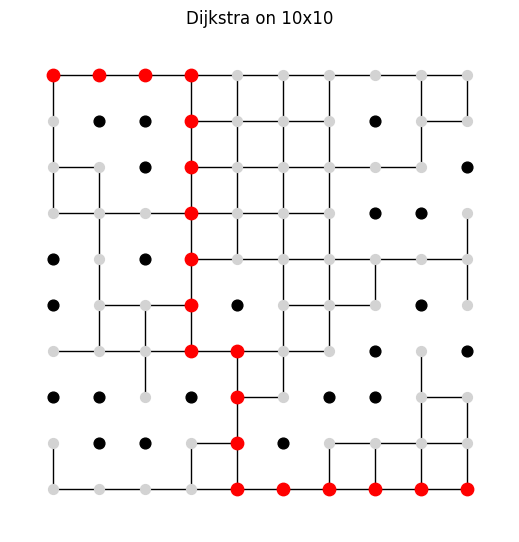

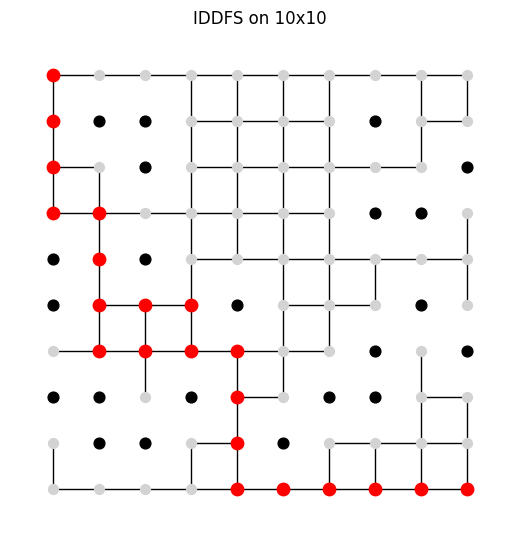

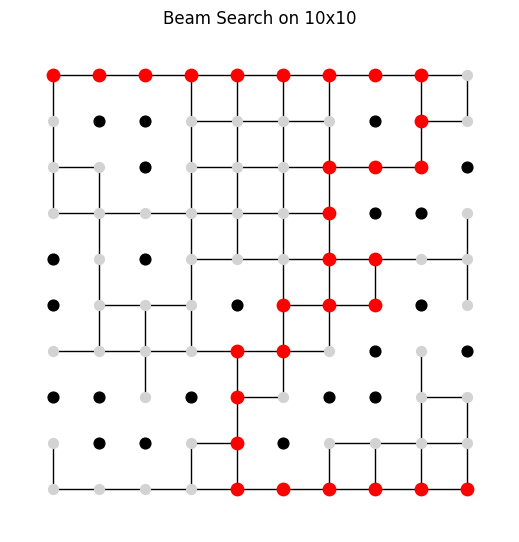

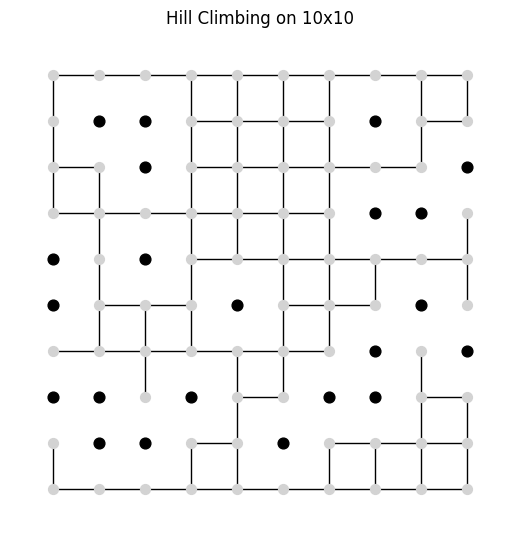


🔎 GRID SIZE: 15x15


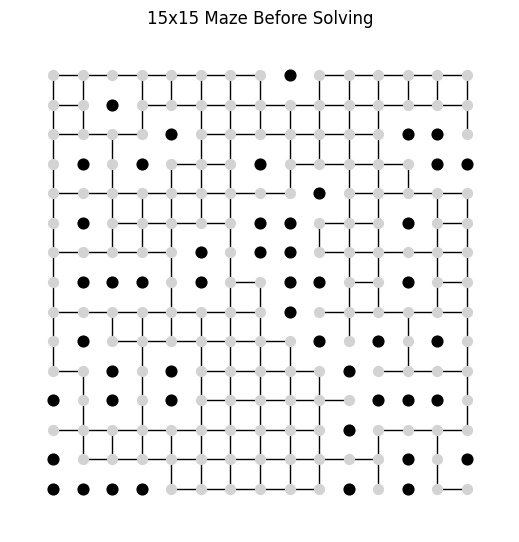

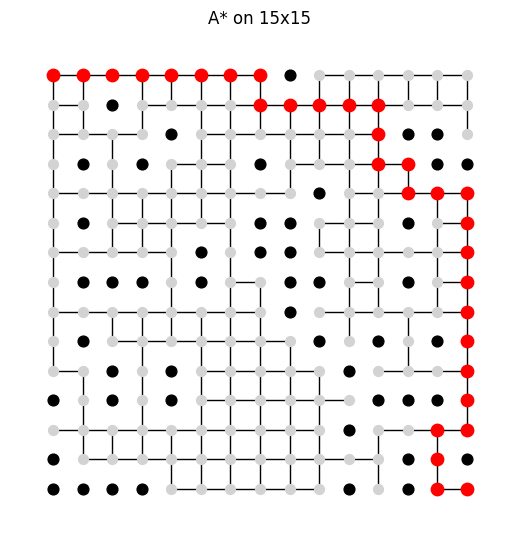

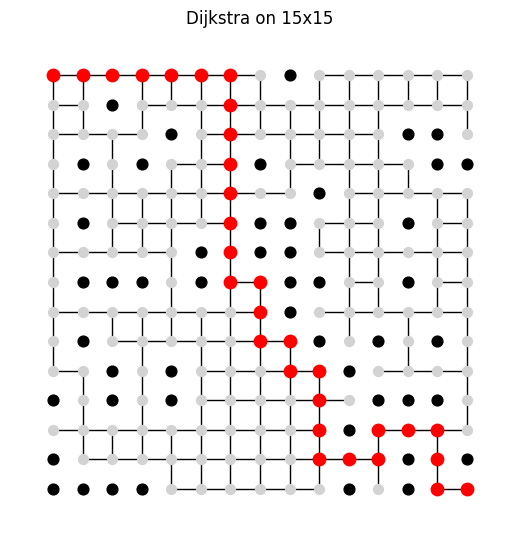

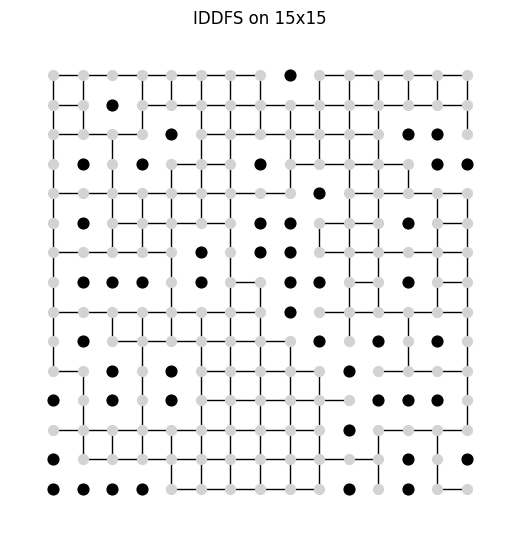

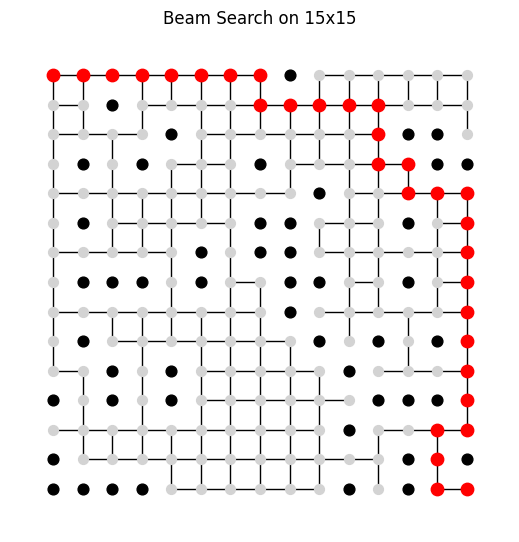

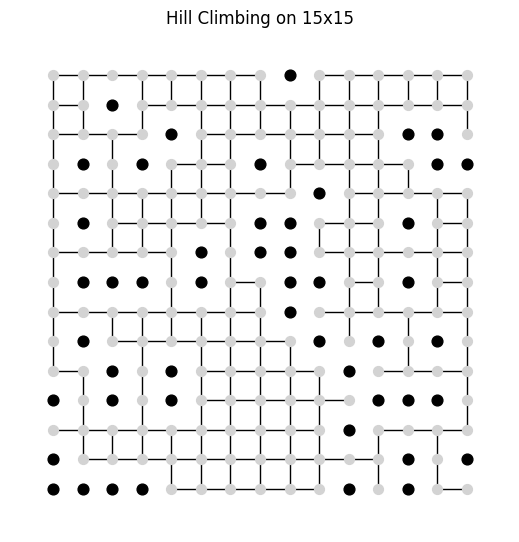

In [18]:
# 🔁 Run Replications
def run_experiments(grid_sizes=[(10, 10), (15, 15)], replications=5):
    algorithms = {
        "A*": astar_search,
        "Dijkstra": dijkstra_search,
        "IDDFS": iddfs_search,
        "Beam Search": beam_search,
        "Hill Climbing": hill_climbing_search
    }

    all_results = []

    for rows, cols in grid_sizes:
        print(f"\n🔎 GRID SIZE: {rows}x{cols}")
        for rep in range(replications):
            G, obstacles = create_grid_graph(rows, cols, obstacle_prob=0.2)
            start, goal = (0, 0), (rows - 1, cols - 1)
            if start not in G.nodes or goal not in G.nodes or not nx.has_path(G, start, goal):
                continue

            if rep == 0:
                # Draw the initial unsolved maze
                plt.figure(figsize=(5, 5))
                draw_grid(G, obstacles, title=f"{rows}x{cols} Maze Before Solving")
                plt.show()

            for algo_name, algo_fn in algorithms.items():
                length, time_taken, success = benchmark_search(G, start, goal, algo_fn)
                all_results.append({
                    "Grid Size": f"{rows}x{cols}",
                    "Replication": rep + 1,
                    "Algorithm": algo_name,
                    "Path Length": length,
                    "Execution Time (s)": time_taken,
                    "Success": success
                })

                # Show only 1st maze solution per algorithm per size
                if rep == 0:
                    path = algo_fn(G, start, goal)
                    plt.figure(figsize=(5, 5))
                    draw_grid(G, obstacles, path, title=f"{algo_name} on {rows}x{cols}")
                    plt.show()

    return pd.DataFrame(all_results)

# ✅ Run and collect results
df_all = run_experiments(replications=5)

In [19]:
# 📋 Summary Table for Each Grid
def print_summary_table(df, size):
    print(f"\n📊 Summary for Grid Size: {size}\n")
    subset = df[df["Grid Size"] == size]
    summary = subset.groupby("Algorithm").agg({
        "Path Length": "mean",
        "Execution Time (s)": "mean",
        "Success": "sum"
    }).round(4)
    summary["Success Rate"] = (summary["Success"] / 5).round(2)
    print(tabulate(summary.drop(columns=["Success"]), headers="keys", tablefmt="pretty"))

# 🔍 Generate tables for both sizes
for grid in ["10x10", "15x15"]:
    print_summary_table(df_all, grid)


📊 Summary for Grid Size: 10x10

+---------------+-------------+--------------------+--------------+
|   Algorithm   | Path Length | Execution Time (s) | Success Rate |
+---------------+-------------+--------------------+--------------+
|      A*       |    18.0     |       0.0001       |     0.6      |
|  Beam Search  |   22.6667   |       0.0007       |     0.6      |
|   Dijkstra    |    18.0     |       0.0001       |     0.6      |
| Hill Climbing |    18.0     |       0.0001       |     0.2      |
|     IDDFS     |    22.0     |       0.0007       |     0.6      |
+---------------+-------------+--------------------+--------------+

📊 Summary for Grid Size: 15x15

+---------------+-------------+--------------------+--------------+
|   Algorithm   | Path Length | Execution Time (s) | Success Rate |
+---------------+-------------+--------------------+--------------+
|      A*       |    28.4     |       0.0004       |     1.0      |
|  Beam Search  |    28.8     |       0.0007      

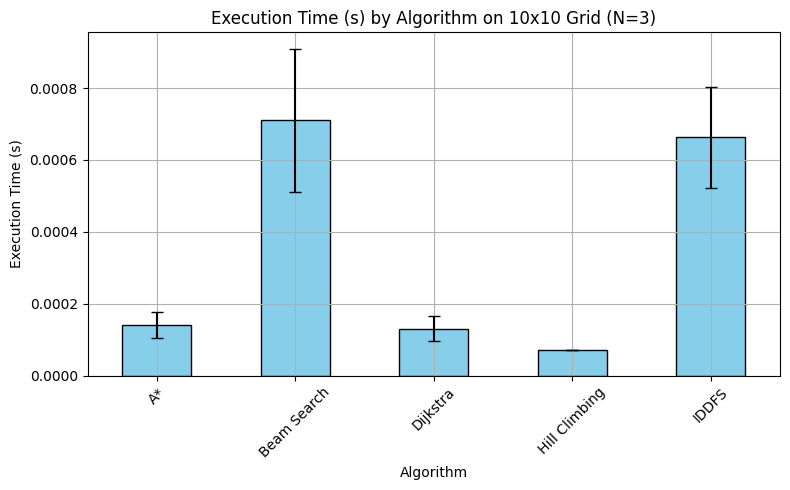

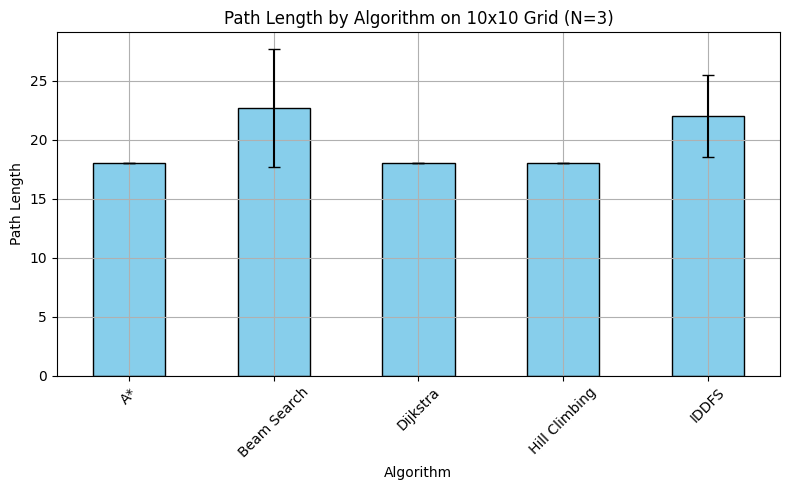

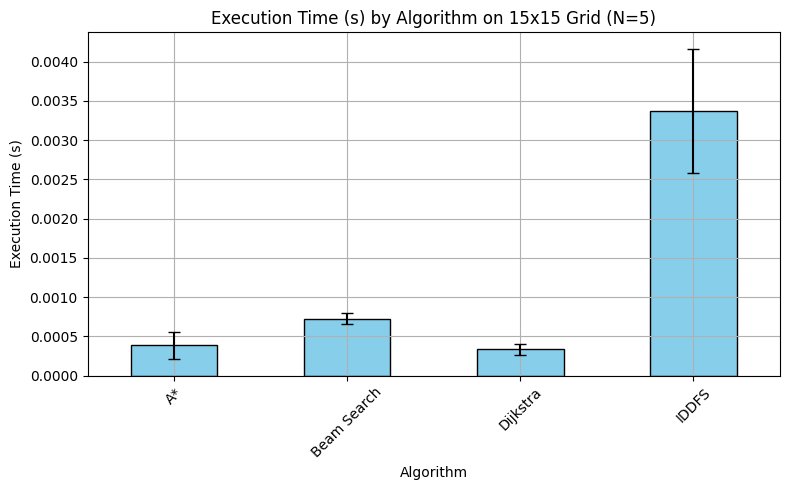

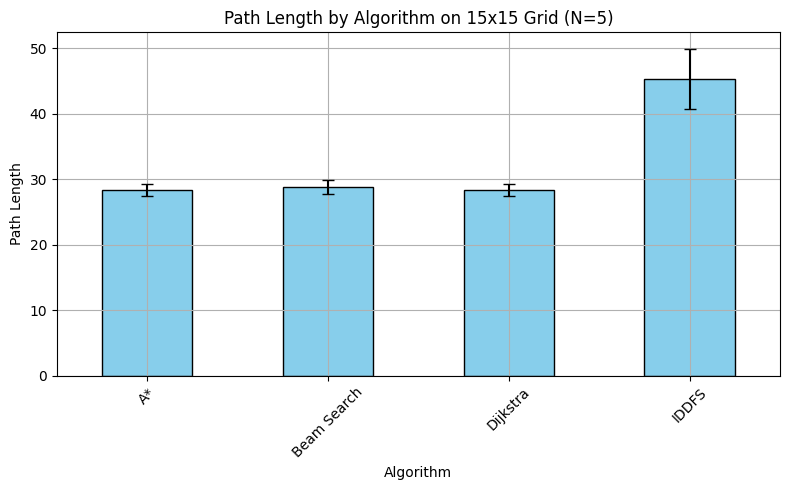

In [20]:
def plot_with_error_bars(df, metric, size):
    subset = df[(df["Grid Size"] == size) & (df["Success"] == True)]
    grouped = subset.groupby("Algorithm")[metric].agg(["mean", "std"])

    if grouped.empty:
        print(f"⚠️ No valid data to plot for {metric} on {size}")
        return

    plt.figure(figsize=(8, 5))
    grouped["mean"].plot.bar(
        yerr=grouped["std"].fillna(0),
        capsize=4, rot=45,
        color='skyblue', edgecolor='black'
    )
    plt.title(f"{metric} by Algorithm on {size} Grid (N={subset['Replication'].nunique()})")
    plt.ylabel(metric)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 📈 Plot for both grid sizes and metrics
for size in ["10x10", "15x15"]:
    for metric in ["Execution Time (s)", "Path Length"]:
        plot_with_error_bars(df_all, metric, size)

In [21]:
def paired_t_test(df, metric, grid_size, algo1="A*", algo2="Dijkstra"):
    subset = df[
        (df["Grid Size"] == grid_size) &
        (df["Success"] == True) &
        (df["Algorithm"].isin([algo1, algo2]))
    ]

    pivot = subset.pivot_table(index="Replication", columns="Algorithm", values=metric)
    a = pivot[algo1].dropna()
    b = pivot[algo2].dropna()

    if len(a) < 2 or len(b) < 2:
        print(f"⚠️ Not enough successful data to compare {algo1} vs. {algo2} on {grid_size} ({metric})")
        return

    t_stat, p_val = ttest_rel(a, b)
    print(f"\n📊 Paired t-test for {metric} on {grid_size} ({algo1} vs {algo2}):")
    print(f"t-statistic = {t_stat:.4f}, p-value = {p_val:.5f}")
    print("✅ Significant" if p_val < 0.05 else "⚠️ Not significant")

# 🔬 Run 4 tests (2 sizes × 2 metrics)
for size in ["10x10", "15x15"]:
    for metric in ["Path Length", "Execution Time (s)"]:
        paired_t_test(df_all, metric, size)


📊 Paired t-test for Path Length on 10x10 (A* vs Dijkstra):
t-statistic = nan, p-value = nan
⚠️ Not significant

📊 Paired t-test for Execution Time (s) on 10x10 (A* vs Dijkstra):
t-statistic = 1.7321, p-value = 0.22540
⚠️ Not significant

📊 Paired t-test for Path Length on 15x15 (A* vs Dijkstra):
t-statistic = nan, p-value = nan
⚠️ Not significant

📊 Paired t-test for Execution Time (s) on 15x15 (A* vs Dijkstra):
t-statistic = 0.9587, p-value = 0.39200
⚠️ Not significant


In [22]:
def print_failures(df, size):
    print(f"\n⏱️ Timeout or failure cases on {size} grid:")
    failures = df[(df["Grid Size"] == size) & (df["Success"] == False)]
    if failures.empty:
        print("✅ All algorithms succeeded.")
    else:
        for row in failures.itertuples():
            print(f"❌ {row.Algorithm} failed in replication {row.Replication} (Time: {row._5:.4f}s)")

# ⏱️ Show failure logs
for grid in ["10x10", "15x15"]:
    print_failures(df_all, grid)


⏱️ Timeout or failure cases on 10x10 grid:
❌ Hill Climbing failed in replication 1 (Time: 0.0001s)
❌ Hill Climbing failed in replication 5 (Time: 0.0001s)

⏱️ Timeout or failure cases on 15x15 grid:
❌ IDDFS failed in replication 1 (Time: 0.0040s)
❌ Hill Climbing failed in replication 1 (Time: 0.0001s)
❌ IDDFS failed in replication 2 (Time: 0.0038s)
❌ Hill Climbing failed in replication 2 (Time: 0.0001s)
❌ Hill Climbing failed in replication 3 (Time: 0.0001s)
❌ Hill Climbing failed in replication 4 (Time: 0.0001s)
❌ Hill Climbing failed in replication 5 (Time: 0.0001s)
